In [1]:
import pandas as pd
import numpy as np
import glob
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats

%cd -q '/Users/hglover/Library/CloudStorage/Box-Box/HannahGlover/Research/data'


In [55]:
def ooi_kd_calc(df):
    # pull out depth and par
    z = np.abs(df['z'].to_numpy())
    par = df['par'].to_numpy()
  
    # remove nans and negative par values (bad data)
    z = z[(par>=0) & ~np.isnan(par)]
    par = par[(par>=0) & ~np.isnan(par)]

    # only calculate over upper 10m
    par = par[z<10]
    z = z[z<10]
    
    # check if theres more than 1 cast
    diff = z[1:] - z[:-1]
    plt.plot(z)
#     if len(z) == 0:
#         kd = np.nan
#         rval = np.nan
#         stderr = np.nan
#     else:
#         # calc ln of par 
#         lnpar = np.log(par)
#         # calculate Kd from the log-linear slope of the light decay
#         fit = stats.linregress(x=z,y=lnpar)
#         par_pred = fit.slope*z + lnpar[0]
#         kd = np.abs(fit.slope)
#         rval = fit.rvalue
#         stderr=np.exp(fit.stderr)

#     return kd,rval,stderr

In [67]:
FF = glob.glob('icesat2/ooi/data*.csv')
FF.sort()

ooi_kd_array = pd.DataFrame(data=None,
                            index=range(len(FF)),
                            columns=['time','lat','lon','kd','rval','stderr','stn']
                           )
jj = 43
df = pd.read_csv(FF[jj],
                 index_col=0,
                 header=0,
                 usecols=[i for i in range(6)],
                 names=['', 'time', 'lat', 'lon', 'z', 'par']
                ) #
df['time'] = pd.to_datetime(df["time"]).round('s')
t = df['time'].to_numpy()-df['time'][0]
print(t)

# pull out depth and par
z = np.abs(df['z'].to_numpy())
par = df['par'].to_numpy()

# remove nans and negative par values (bad data)
z = z[(par>=0) & ~np.isnan(par)]
par = par[(par>=0) & ~np.isnan(par)]

# only calculate over upper 10m
par = par[z<10]
z = z[z<10]

# check if theres more than 1 cast
diff = z[1:] - z[:-1]
plt.plot(z)
#     if len(z) == 0:
#         kd = np.nan
#         rval = np.nan
#         stderr = np.nan
#     else:
#         # calc ln of par 
#         lnpar = np.log(par)
#         # calculate Kd from the log-linear slope of the light decay
#         fit = stats.linregress(x=z,y=lnpar)
#         par_pred = fit.slope*z + lnpar[0]
#         kd = np.abs(fit.slope)
#         rval = fit.rvalue
#         stderr=np.exp(fit.stderr)

TypeError: unsupported operand type(s) for -: 'numpy.ndarray' and 'Timestamp'

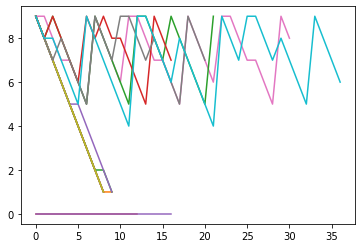

In [56]:
# calculate Kd from OOI data


FF = glob.glob('icesat2/ooi/data*.csv')
FF.sort()

ooi_kd_array = pd.DataFrame(data=None,
                            index=range(len(FF)),
                            columns=['time','lat','lon','kd','rval','stderr','stn']
                           )

for jj in range(len(FF)):
    df = pd.read_csv(FF[jj],
                     index_col=0,
                     header=0,
                     usecols=[i for i in range(6)],
                     names=['', 'time', 'lat', 'lon', 'z', 'par']
                    ) #
    ooi_kd_array.loc[jj,'stn'] = FF[jj][9:-4]
    ooi_kd_calc(df)
#    kd,rval,stderr = ooi_kd_calc(df)
    
#     try:
#         kd,rval,stderr = ooi_kd_calc(df)
#     except:
#         kd = np.nan
#         rval = np.nan
#         stderr = np.nan

#     time = df.loc[1,'time']
#     lat = df.loc[1,'lat']
#     lon = df.loc[1,'lon']

#     ooi_kd_array.loc[jj,'time'] = time
#     ooi_kd_array.loc[jj,'lat'] = lat
#     ooi_kd_array.loc[jj,'lon'] = lon
#     ooi_kd_array.loc[jj,'kd'] = kd
#     ooi_kd_array.loc[jj,'rval'] = rval
#     ooi_kd_array.loc[jj,'stderr'] = stderr


# pd.DataFrame()
# d = {'time' = ff[0,1],'kd': m, 'rval': rval, 'stderr': stderr}
# df = pd.DataFrame(data=d)

# ooi_kd_array.to_csv('../output/icesat2/ooi_kdcalculations10m.csv')
#ooi_kd_array

In [6]:
# calculate kd for all of gulf of mexico ctd profiles 
FF = glob.glob('icesat2/ctd_ws/data*.csv')
FF.sort()

ws_kd_array = pd.DataFrame(data=None,
                            index=range(len(FF)),
                            columns=['time','lat','lon','kd','rval','stderr','stn']
                           )

for jj in range(len(FF)):
    df = pd.read_csv(FF[jj],
                     index_col=0,
                     header=0,
                     usecols=[i for i in [0,2,3,4,5,6,28]],
                     names=['','prof', 'time', 'lat', 'lon', 'z', 'par']
                    )
    ws_kd_array.loc[jj,'stn'] = FF[jj][12:-4]
    
    try:
        kd,rval,stderr = ooi_kd_calc(df)
    except:
        kd = np.nan
        rval = np.nan
        stderr = np.nan

    time = df.loc[1,'time']
    lat = df.loc[1,'lat']
    lon = df.loc[1,'lon']

    ws_kd_array.loc[jj,'time'] = time
    ws_kd_array.loc[jj,'lat'] = lat
    ws_kd_array.loc[jj,'lon'] = lon
    ws_kd_array.loc[jj,'kd'] = kd
    ws_kd_array.loc[jj,'rval'] = rval
    ws_kd_array.loc[jj,'stderr'] = stderr



pname = '../output/icesat2/'
ws_kd_array.to_csv(pname+'ws_kdcalculations10m.csv')
ws_kd_array

,time,lat,lon,kd,rval,stderr,stn
0,2018-12-18T08:19:41Z,24.597167,-81.181333,0.142587,-0.504765,1.007733,ws/data_WS18351_WS18351_STA18
1,2020-08-20T00:54:19Z,25.404333,-82.2105,0.000843,-0.009688,1.00203,ws/data_WS20231_WS20231_STA_30
2,2020-10-09T09:36:26Z,26.632167,-82.5595,4.157565,-0.825658,1.070123,ws/data_WS20279_WS20279_WS20278_Stn_BG4
3,2022-12-06T19:31:24Z,27.796667,-82.879667,0.178231,-0.59098,1.004571,ws/data_WS22337_WS22337_WS22337_Stn_TB1
4,2022-12-06T20:09:35Z,27.7405,-82.928333,0.064517,-0.448053,1.0023,ws/data_WS22337_WS22337_WS22337_Stn_TB2


In [4]:
# Process BCODMO data : only keep unique entries to search ICESat-2
FF = glob.glob('bcodmo/*.csv')
FF.sort()

for jj in range(len(FF)):
    df = pd.read_csv(FF[jj],header=0)
    df.drop(0,inplace=True)
    df = df.drop_duplicates(subset=['time'])
    df.reset_index(drop=True, inplace=True)

    print(FF[jj])
    print(df.head())
    
    fname = FF[jj][:-4]+'_unique.pkl'
    df.to_pickle(fname)



bcodmo/bcodmo_dataset_518582_2e2e_e9a0_6c3e.csv
  cast latitude  longitude depth_w                  time     par
0   01   21.391  -158.2908    1323  2013-07-02T04:14:31Z  383.36
1   01    22.75  -158.0002    4743  2013-07-02T21:55:50Z  3588.1
2   02    22.75  -158.0003    4742  2013-07-03T13:53:21Z  2.2892
3   01  24.0882   -157.999    4496  2013-07-03T21:56:40Z  1001.3
4   01  27.0658  -157.9975    5392  2013-07-04T13:59:16Z  1.9284
bcodmo/bcodmo_dataset_757784_f8fc_ca99_ecce.csv
  Station       Site                  time depth     Par  latitude  longitude
0     001  Shakedown  2018-05-07T17:46:00Z   3.0  1460.0  11.24758  -56.32338
1     001  Shakedown  2018-05-07T17:47:00Z   7.0   169.0  11.24768  -56.32336
2     001  Shakedown  2018-05-07T17:48:00Z  30.0    45.1  11.24788  -56.32324
3     001  Shakedown  2018-05-07T17:49:00Z  56.0    14.8  11.24816  -56.32307
4     001  Shakedown  2018-05-07T17:50:00Z  85.0    3.71  11.24842  -56.32296
bcodmo/bcodmo_dataset_774958_89bb_d996_f2f0.cs

In [20]:
# Process BCODMO data
FF = glob.glob('bcodmo/*.csv')
FF.sort()

# ws_kd_array = pd.DataFrame(data=None,
#                             index=range(len(FF)),
#                             columns=['time','lat','lon','kd','rval','stderr','stn']
#                            )
jj = 1

df = pd.read_csv(FF[jj],
                 header=0)
df = df.drop_duplicates(subset=['time'])
df.head()

,Station,Site,time,depth,Par,latitude,longitude
0,unitless,unitless,UTC,m,micromoles photons per square meter per second...,degrees_north,degrees_east
1,001,Shakedown,2018-05-07T17:46:00Z,3.0,1460.0,11.24758,-56.32338
5,001,Shakedown,2018-05-07T17:47:00Z,7.0,169.0,11.24768,-56.32336
28,001,Shakedown,2018-05-07T17:48:00Z,30.0,45.1,11.24788,-56.32324
54,001,Shakedown,2018-05-07T17:49:00Z,56.0,14.8,11.24816,-56.32307
